In [318]:
#!pip install python-louvain (https://github.com/taynaud/python-louvain/blob/master/README.rst)
# run in Python 3.10.7

For amazon, an item can belong to multiple or none of the community

In [319]:
import networkx as nx
import time
import numpy as np
from cdlib import evaluation, NodeClustering
import matplotlib.pyplot as plt

import community.community_louvain as community_louvain
import leidenalg as la
import igraph as ig
from collections import defaultdict

from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, confusion_matrix
from scipy.optimize import linear_sum_assignment

# Data Visualization

### True Graph

We only extract the subgraph where the nodes are labeled in the `com-amazon.top5000.cmty.txt` file.

In [320]:
# true_labels is a dict, where each key is a node, and each value is a list that contains the communities it belongs to
original_true_labels = defaultdict(list)
# Read the .txt file
with open('amazon/com-amazon.top5000.cmty.txt', 'r') as file:
    i = 0
    for line in file:
        L_nodes = line.strip().split()
        for node in L_nodes:
            original_true_labels[int(node)].append(i)
        i+=1

In [321]:
# Transform train samples into a graph
original_G = nx.Graph()

# Read the .txt file
with open('amazon/com-amazon.ungraph.txt', 'r') as file:
    for line in file:
        node1, node2 = line.strip().split()

        if int(node1) in original_true_labels.keys() and int(node2) in original_true_labels.keys():
            original_G.add_edge(int(node1), int(node2))

# Display the graph info
print("The number of nodes: {}".format(original_G.number_of_nodes()))
print("The number of edges: {}".format(original_G.number_of_edges()))
print("Graph is connected: ", nx.is_connected(original_G), "\n")

print(f"Number of connected components: {nx.number_connected_components(original_G)}")
largest_component = max(list(nx.connected_components(original_G)), key=len)
print(f"The largest component has {len(largest_component)} nodes.")

The number of nodes: 16716
The number of edges: 48739
Graph is connected:  False 

Number of connected components: 1106
The largest component has 475 nodes.


Because `original_G` has many connected components, we plan to only keep the biggest one, and to relabel the nodes and the communities with integers from $0$.

In [322]:
# Create a subgraph of the largest component
G = original_G.subgraph(largest_component).copy()

# true_labels is a dict, where each key is a node, and each value is a list that contains the communities it belongs to
true_labels = defaultdict(list)
# Read the .txt file
with open('amazon/com-amazon.top5000.cmty.txt', 'r') as file:
    i = 0
    for line in file:
        L_nodes = line.strip().split()
        for node in L_nodes:
            if int(node) in G.nodes():
                true_labels[int(node)].append(i)
        i+=1

In [323]:
#  Removing community IDs that are always shared together

# Step 1: Build a mapping from each community ID to the set of nodes it appears in
community_to_nodes = defaultdict(set)

for node, comms in true_labels.items():
    for comm in comms:
        community_to_nodes[comm].add(node)

# Step 2: Detect and mark redundant communities
to_remove = set()
communities = list(community_to_nodes.items())

for i in range(len(communities)):
    c1, nodes1 = communities[i]
    for j in range(i+1, len(communities)):
        c2, nodes2 = communities[j]
        # If communities always appear together, mark one for removal
        if nodes1 == nodes2:
            to_remove.add(c2)  # arbitrarily remove c2

# Step 3: Clean the original dict
true_labels = {
    node: [c for c in comms if c not in to_remove]
    for node, comms in true_labels.items()
}

In [324]:
# Relabel nodes
old_node_labels = list(G.nodes())
old2new_nodes = {old_node_labels[i]: i  for i in range(len(true_labels))}

true_labels = {old2new_nodes.get(k, k): v for k, v in true_labels.items()}
G = nx.relabel_nodes(G, old2new_nodes)

In [325]:
# Relabelling communities
L = []
for node in true_labels:
    new_L_com = []
    for com in true_labels[node]:
        if com not in L:
            L.append(com)
        new_L_com.append(L.index(com))
    true_labels[node] = new_L_com

In [326]:
true_labels

{386: [0, 1, 2],
 14: [0, 2],
 370: [0, 1, 2],
 17: [0, 1, 2],
 384: [0, 1, 2],
 268: [0, 1, 2],
 398: [0, 1, 2],
 11: [0, 1, 2],
 40: [0, 1, 2],
 445: [3, 2],
 472: [3, 2],
 252: [3, 2],
 57: [3, 2],
 210: [3, 2],
 4: [3, 2],
 151: [3, 2],
 199: [3, 2],
 200: [3, 2],
 121: [3, 2],
 91: [3, 2],
 86: [3, 2],
 412: [3, 2],
 326: [3, 2],
 253: [4, 5],
 418: [4, 5],
 419: [4, 5],
 368: [4, 5],
 369: [4, 5],
 372: [4, 5],
 406: [4, 5],
 408: [4, 5],
 82: [4, 5],
 42: [4, 5],
 288: [4, 5],
 289: [4, 5],
 15: [4, 5],
 16: [4, 5],
 237: [6, 5],
 323: [6, 5],
 118: [6, 7, 5],
 294: [6, 5],
 295: [6, 5],
 339: [6, 5],
 343: [6, 5],
 344: [6, 5],
 375: [6, 7, 5],
 219: [6, 5],
 250: [6, 7, 5],
 85: [6, 7, 5],
 240: [6, 7, 5],
 256: [6, 5],
 2: [6, 5],
 73: [6, 5],
 74: [6, 5],
 76: [6, 5],
 239: [6, 5],
 135: [6, 7, 5],
 125: [6, 5],
 404: [6, 7, 5],
 405: [6, 7, 5],
 265: [6, 7, 5],
 300: [6, 5],
 301: [6, 5],
 271: [6, 5],
 272: [6, 5],
 273: [6, 5],
 274: [6, 5],
 275: [6, 5],
 38: [6, 5],
 52

### Results

In [327]:
# Final information
print("The number of nodes: {}".format(G.number_of_nodes()))
print("The number of edges: {}".format(G.number_of_edges()))
print("Graph is connected: ", nx.is_connected(G), "\n")

print(f"Number of communities: {len(L)}")


The number of nodes: 475
The number of edges: 1184
Graph is connected:  True 

Number of communities: 18


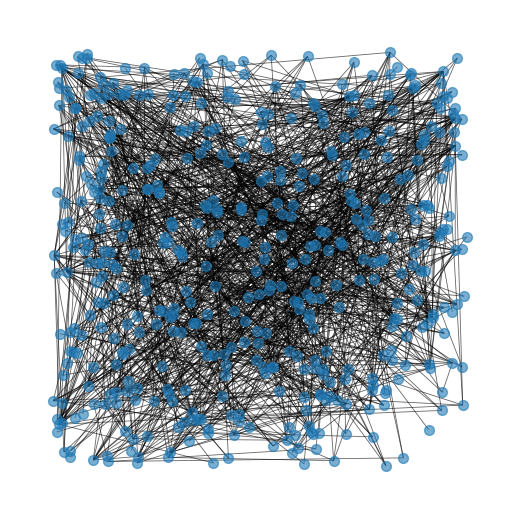

In [328]:
# Plot graph
plt.figure(figsize=(5,5))
pos = nx.random_layout(G, seed=42)
nx.draw(G, with_labels=False,  pos = pos, node_size = 50, alpha = 0.6, width = 0.6)
plt.show()

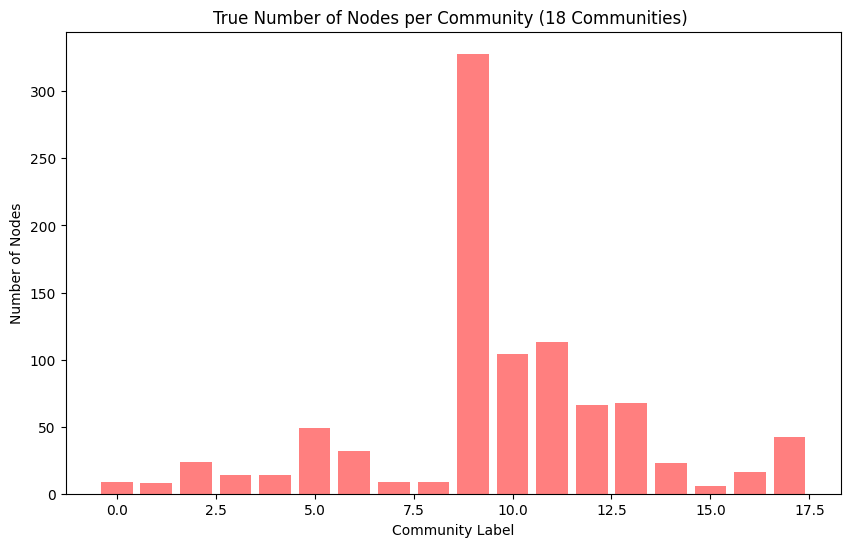

In [329]:
# Extract community labels and the corresponding number of nodes
true_com = defaultdict(int)
for node, coms in true_labels.items():
        for x in coms:
            true_com[x] += 1
        
true_communities = list(true_com.keys())  # Community labels
true_sizes = list(true_com.values())  # Number of nodes in each community

# Plot the data
plt.figure(figsize=(10, 6))
plt.bar(true_communities, true_sizes, color='red', alpha=0.5)

# Add labels and title
plt.xlabel('Community Label')
plt.ylabel('Number of Nodes')
plt.title(f'True Number of Nodes per Community ({len(true_com)} Communities) ')

# Display the plot
plt.show()

### Useful functions

Same functions, we just format the initial dict with list as values (not only int)

In [330]:
def show_boxplot(dict_labels: dict, algo_name: str):
    
    ### Extract community labels and the corresponding number of nodes, for the true labels
    true_com = defaultdict(int)
    for node, coms in true_labels.items():
            for x in coms:
                true_com[x] += 1
            
    true_communities = list(true_com.keys())  # Community labels
    true_sizes = list(true_com.values())  # Number of nodes in each community


    ### Extract community labels and the corresponding number of nodes, for the predicted labels
    count_com = defaultdict(int)
    for node, coms in dict_labels.items():
            for x in coms:
                count_com[x] += 1

    communities = [] # Community labels
    sizes = [] # Number of nodes in each community
    for com in range(max(len(true_com), len(count_com))):
            communities.append(com)
            if com in list(count_com.keys()):
                    sizes.append(count_com[com])
            else:
                    sizes.append(0)

    # Plot the data in louvain
    plt.figure(figsize=(10, 6))
    plt.bar(communities, sizes, alpha=0.5, label=f"{algo_name}")
    plt.bar(true_communities, true_sizes, alpha=0.5, label="True labels")

    # Add labels and title
    plt.xlabel('Community Label')
    plt.ylabel('Number of Nodes')
    plt.title(f'Number of Nodes per Community for {algo_name} ({len(count_com)} Communities)')

    # Display the plot
    plt.legend()
    plt.show()

In [331]:
def scores(dict_labels: dict, algo_name: str):

    s = 0
    for node in G.nodes():
        for x in true_labels[node]:
            if x in dict_labels[node]:
                s += 1 / len(true_labels)
    print(f"Accuracy for {algo_name}: {s/len(G.nodes):.4f}")

    # Convert to community-to-nodes format
    com_to_nodes = defaultdict(set)
    for node, coms in dict_labels.items():
        for com in coms:
            com_to_nodes[com].add(node)
    pred_communities = list(com_to_nodes.values())

     # Convert to community-to-nodes format
    com_to_nodes = defaultdict(set)
    for node, coms in true_labels.items():
        for com in coms:
            com_to_nodes[com].add(node)
    true_communities = list(com_to_nodes.values())

    # Convert to cdlib format
    true_clusters = NodeClustering(communities=true_communities, graph=G, method_name="ground_truth")
    pred_clusters = NodeClustering(communities=pred_communities, graph=G, method_name="predicted")
    # Compute Omega Index
    omega = evaluation.omega(true_clusters, pred_clusters)
    print(f"Omega Index for {algo_name}: {omega.score:.4f}")


In [332]:
def align_labels(dict_labels):

    # number of predicted communities
    n1 = 0
    for node in dict_labels:
        for x in dict_labels[node]:
            if x > n1:
                n1 = x
    n1 += 1

    # true number of communities
    n2 = 0
    for node in true_labels:
        for x in true_labels[node]:
            if x > n2:
                n2 = x
    n2 += 1

    # Create confusion matrix
    cm = np.zeros((max(n1,n2), max(n1,n2)))
    for node in dict_labels:
        for i in true_labels[node]:
            for j in dict_labels[node]:
                cm[i, j] = 1

    # Use Hungarian algorithm to find best matching
    row_ind, col_ind = linear_sum_assignment(-cm)  # maximize total score
    
    # Create a mapping from predicted label → true label
    mapping = {col: row for row, col in zip(row_ind, col_ind)}
    
    return mapping

# Louvain

In [348]:
start = time.time()

# Apply Louvain algorithm
louvain_partition = community_louvain.best_partition(G, resolution=1, random_state=42)

for node in louvain_partition:
    louvain_partition[node] = [louvain_partition[node]]

# Align labels
mapping = align_labels(louvain_partition)
#print("Mapping (pred → true):", mapping)

# Assign each node the corresponding true label
louvain_labels = defaultdict(list)
for node in louvain_partition:
    for x in louvain_partition[node]:
        louvain_labels[node].append(mapping[x])

duration = time.time() - start

print(louvain_labels)

defaultdict(<class 'list'>, {0: [10], 1: [15], 2: [5], 3: [10], 4: [2], 5: [3], 6: [6], 7: [16], 8: [3], 9: [15], 10: [9], 11: [0], 12: [8], 13: [15], 14: [0], 15: [4], 16: [4], 17: [0], 18: [14], 19: [3], 20: [4], 21: [10], 22: [6], 23: [16], 24: [16], 25: [11], 26: [3], 27: [12], 28: [11], 29: [16], 30: [7], 31: [11], 32: [1], 33: [6], 34: [6], 35: [1], 36: [11], 37: [13], 38: [5], 39: [2], 40: [0], 41: [7], 42: [4], 43: [7], 44: [17], 45: [6], 46: [7], 47: [1], 48: [6], 49: [15], 50: [1], 51: [17], 52: [8], 53: [3], 54: [15], 55: [3], 56: [14], 57: [2], 58: [15], 59: [11], 60: [7], 61: [3], 62: [11], 63: [14], 64: [10], 65: [3], 66: [3], 67: [17], 68: [3], 69: [3], 70: [15], 71: [9], 72: [9], 73: [5], 74: [5], 75: [11], 76: [5], 77: [9], 78: [10], 79: [10], 80: [17], 81: [17], 82: [4], 83: [3], 84: [4], 85: [4], 86: [2], 87: [14], 88: [9], 89: [14], 90: [14], 91: [2], 92: [9], 93: [3], 94: [3], 95: [3], 96: [6], 97: [3], 98: [7], 99: [1], 100: [9], 101: [7], 102: [10], 103: [15], 10

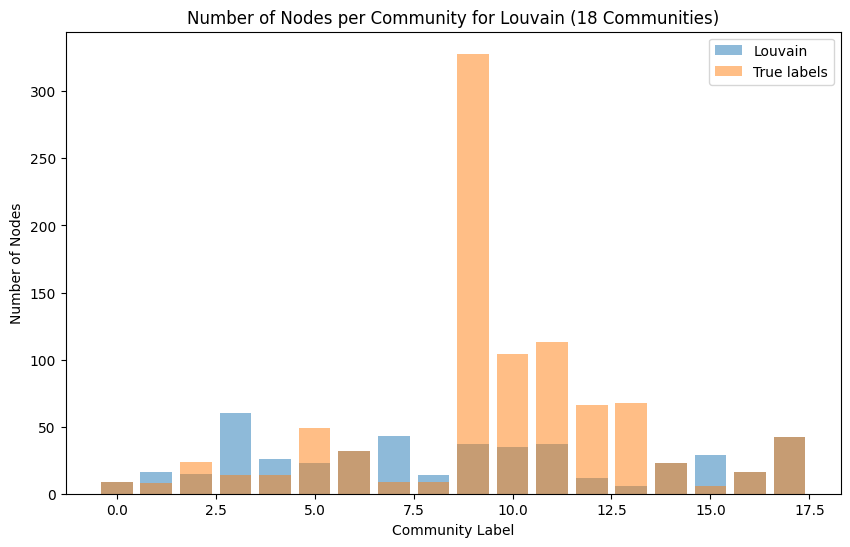

Accuracy for Louvain: 0.0012
Omega Index for Louvain: 0.1053
Time for Louvain: 0.0414 s


In [349]:
algo_name = "Louvain"

show_boxplot(louvain_labels, algo_name)
scores(louvain_labels, algo_name)
print(f"Time for {algo_name}: {duration:.4f} s")

## Leiden

In [350]:
# The implemented Leiden needs igraph format
G_ig = ig.Graph.from_networkx(G)

In [351]:
start = time.time()
partition = la.find_partition(G_ig, la.RBConfigurationVertexPartition, resolution_parameter=3, seed=42)

# Print community assignments
leiden_partition = {node: com for node, com in zip(G.nodes(), partition.membership)}

for node in leiden_partition:
    leiden_partition[node] = [leiden_partition[node]]

# Align labels
mapping = align_labels(leiden_partition)
#print("Mapping (pred → true):", mapping)

# Assign each node the corresponding true label
leiden_labels = defaultdict(list)
for node in leiden_partition:
    for x in leiden_partition[node]:
        leiden_labels[node].append(mapping[x])

duration = time.time() - start

print(leiden_labels)

defaultdict(<class 'list'>, {0: [11], 1: [26], 2: [5], 3: [11], 4: [2], 5: [3], 6: [9], 7: [16], 8: [1], 9: [26], 10: [20], 11: [0], 12: [8], 13: [18], 14: [0], 15: [4], 16: [4], 17: [0], 18: [13], 19: [1], 20: [4], 21: [23], 22: [9], 23: [27], 24: [27], 25: [10], 26: [1], 27: [25], 28: [10], 29: [16], 30: [22], 31: [12], 32: [24], 33: [9], 34: [9], 35: [24], 36: [12], 37: [15], 38: [5], 39: [2], 40: [0], 41: [7], 42: [4], 43: [7], 44: [19], 45: [9], 46: [22], 47: [24], 48: [9], 49: [18], 50: [24], 51: [17], 52: [8], 53: [23], 54: [18], 55: [1], 56: [13], 57: [2], 58: [18], 59: [12], 60: [22], 61: [3], 62: [12], 63: [13], 64: [11], 65: [3], 66: [1], 67: [19], 68: [1], 69: [3], 70: [18], 71: [21], 72: [20], 73: [5], 74: [5], 75: [12], 76: [5], 77: [21], 78: [23], 79: [23], 80: [19], 81: [19], 82: [4], 83: [3], 84: [4], 85: [6], 86: [2], 87: [13], 88: [21], 89: [13], 90: [13], 91: [2], 92: [20], 93: [1], 94: [3], 95: [3], 96: [9], 97: [1], 98: [22], 99: [24], 100: [20], 101: [7], 102: [1

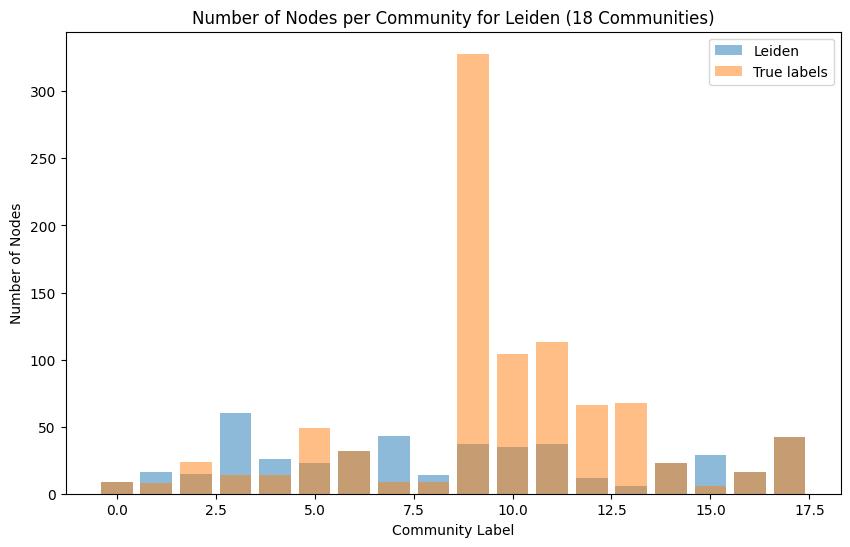

Accuracy for Leiden: 0.0010
Omega Index for Leiden: 0.0563
Time for Leiden: 0.0239 s


In [352]:
algo_name = "Leiden"

show_boxplot(louvain_labels, algo_name)
scores(leiden_labels, algo_name)
print(f"Time for {algo_name}: {duration:.4f} s")

# Cliqued Louvain

In [338]:
def find_k_cliques(G, k):
    """Find all cliques of size exactly k."""
    return [clique for clique in nx.find_cliques(G) if len(clique) == k]


def reconstruct_graph(G, k_cliques):
    """
    Replace each k-clique with a supernode and add self-loops.
    Maintain non-classified nodes (NCNs).
    """
    H = nx.Graph()
    node_to_clique = {}
    supernode_id = 0

    # Step 2: Convert each clique to a supernode with self-loop
    for clique in k_cliques:
        supernode = f"C{supernode_id}"
        supernode_id += 1
        H.add_node(supernode)
        num_edges = len(clique) * (len(clique) - 1) // 2
        H.add_edge(supernode, supernode, weight=num_edges)
        for node in clique:
            node_to_clique.setdefault(node, []).append(supernode)

    # Step 3: Add remaining nodes and original edges
    for u, v in G.edges():
        clique_u = node_to_clique.get(u, None)
        clique_v = node_to_clique.get(v, None)

        if clique_u is None and clique_v is None:
            # Both are NCNs
            H.add_edge(u, v)
        elif clique_u is None:
            # u is NCN, v is in clique(s)
            for v_clique in clique_v:
                H.add_edge(u, v_clique)
        elif clique_v is None:
            # v is NCN, u is in clique(s)
            for u_clique in clique_u:
                H.add_edge(v, u_clique)
        else:
            # Both are part of cliques
            for cu in clique_u:
                for cv in clique_v:
                    if cu != cv:
                        H.add_edge(cu, cv)

    return H


def apply_louvain(H, resolution=1.0):
    """Apply Louvain and return community partition."""
    partition = community_louvain.best_partition(H, resolution=resolution)
    communities = {}
    for node, comm_id in partition.items():
        communities.setdefault(comm_id, []).append(node)
    return list(communities.values()), partition


def clique_based_louvain_cbla(G, k, resolution=1.0):
    """
    Main function for Clique-Based Louvain Algorithm (CBLA).
    Based on provided algorithm steps.
    """
    k_cliques = find_k_cliques(G, k)
    reconstructed_graph = reconstruct_graph(G, k_cliques)

    # Step 4: Apply Louvain until NCNs are assigned
    communities, partition = apply_louvain(reconstructed_graph, resolution)

    # Map back to original nodes
    node_assignments = {}
    for comm_id, nodes in enumerate(communities):
        for node in nodes:
            if isinstance(node, str) and node.startswith("C"):
                # Clique supernode: map to original clique nodes
                idx = int(node[1:])
                for original_node in k_cliques[idx]:
                    node_assignments.setdefault(original_node, set()).add(comm_id)
            else:
                # NCN node
                node_assignments.setdefault(node, set()).add(comm_id)

    return node_assignments

In [339]:
start = time.time()

k = 2 # Choose minimum clique size
resolution = 0.7
cb_louvain_partition = clique_based_louvain_cbla(G, k, resolution)
for node in cb_louvain_partition:
    cb_louvain_partition[node] = list(cb_louvain_partition[node])

# Align labels
mapping = align_labels(cb_louvain_partition)
#print("Mapping (pred → true):", mapping)

# Assign each node the corresponding true label
cb_louvain_labels = {node: [mapping[i] for i in cb_louvain_partition[node]] for node in cb_louvain_partition}
duration = time.time() - start

print(cb_louvain_labels)

{1: [2, 1], 9: [2], 364: [2, 6], 357: [2], 147: [2], 32: [2], 47: [2], 190: [2], 50: [2], 134: [2], 60: [2], 376: [2], 95: [2, 7], 179: [2], 99: [2], 232: [2], 101: [2], 303: [2], 105: [2], 124: [2, 1, 3], 133: [2], 362: [2, 7], 149: [2], 163: [2], 456: [2, 1], 171: [2], 213: [2], 186: [2], 202: [2], 361: [2], 208: [2], 231: [2], 388: [2], 297: [2], 306: [2, 3], 325: [2], 447: [2], 468: [2], 439: [2], 448: [2], 385: [2], 452: [2], 457: [2], 30: [2], 387: [2], 465: [2], 122: [2], 260: [2], 35: [2], 345: [2], 443: [2], 41: [2], 43: [2], 188: [2], 332: [2], 281: [2], 318: [2], 394: [2], 470: [2], 458: [2], 129: [2], 143: [2], 340: [2], 230: [1], 10: [1], 117: [1], 12: [1], 464: [1], 258: [1], 49: [1], 54: [1], 58: [1], 70: [1], 103: [1], 92: [1], 178: [1], 100: [1], 315: [1], 107: [1], 290: [1], 115: [1, 7], 128: [1], 352: [1], 244: [1], 257: [1], 392: [1], 299: [1], 451: [1], 278: [1, 8], 354: [1], 13: [1], 189: [1], 321: [1], 346: [1], 72: [1], 442: [1], 114: [1], 423: [1], 420: [1], 19

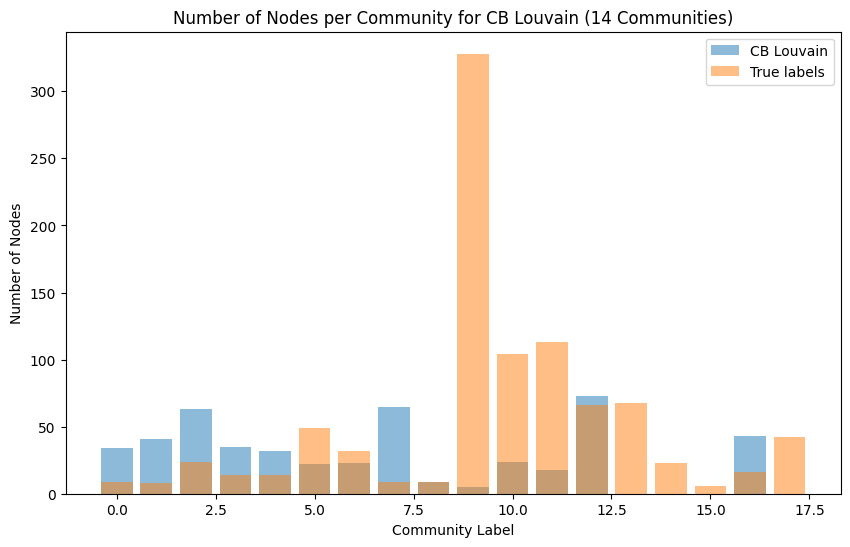

Accuracy for CB Louvain: 0.0006
Omega Index for CB Louvain: 0.1272
Time for CB Louvain: 0.0375 s


In [340]:
algo_name = "CB Louvain"

show_boxplot(cb_louvain_labels, algo_name)
scores(cb_louvain_labels, algo_name)
print(f"Time for {algo_name}: {duration:.4f} s")